In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
from glob import glob
import time
from scipy.stats import spearmanr, pearsonr
from itertools import cycle, islice
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = 'Helvetica'
from matplotlib.backends.backend_pdf import PdfPages
from amb import *
import matplotlib.patches as patches
from scipy.stats import zscore

In [2]:
colordict = get_age_palette()
colordict['8wk'] = colordict['2mo']

In [3]:
indir = 'gen_contact_decay/'
meta = pd.read_csv('/data/metadata/m3C_META_230814.csv', index_col = 0)
meta['Cis/Trans'] = meta['TotalCisContacts']/meta['TotalTransContacts']
decay = pd.concat([pd.read_hdf(xx, key='data') for xx in glob(f'{indir}/pool_*/*.contact_distance_decay.hdf5')], axis=0)

In [4]:
shared_cells = list(set(meta.index) & set(decay.index))
decay = decay.loc[shared_cells].copy()
meta = meta.loc[shared_cells].copy()

In [5]:
decay = decay / decay.sum(axis=1)[:,None]

In [6]:
count = meta['Region'].value_counts()
meta = meta[meta['Region'].isin(count.index[count>1000])]
meta.head()

InputReadPairs  InputReadPairsBP  \
cell                                                                         
AMB_220630_18mo_13D_14C_1_P4-2-G10-E16           2629180         795019915   
AMB_220719_18mo_8E_9H_8J_9J_2_P4-1-D8-H2         2812660         850877247   
AMB_220714_18mo_3F_4E_2_P3-5-C10-I22             1885759         570241072   
AMB_220712_18mo_12D_13B_2_P2-3-M9-J5             1743867         527038721   
AMB_220531_9mo_2A_3A_1_P3-2-C21-M3               2216114         669494081   

                                          TrimmedReadPairs  R1WithAdapters  \
cell                                                                         
AMB_220630_18mo_13D_14C_1_P4-2-G10-E16             2628790             461   
AMB_220719_18mo_8E_9H_8J_9J_2_P4-1-D8-H2           2811652             471   
AMB_220714_18mo_3F_4E_2_P3-5-C10-I22               1885197             125   
AMB_220712_18mo_12D_13B_2_P2-3-M9-J5               1743149            1279   
AMB_220531_9mo_2A_3A_1_P3-2-C21-M3                 2215523             623   

                                          R1QualTrimBP  R1TrimmedReadsBP  \
cell                                                                       
AMB_220630_18mo_13D_14C_1_P4-2-G10-E16         1169311         333249718   
AMB_220719_18mo_8E_9H_8J_9J_2_P4-1-D8-H2       1092323         356864601   
AMB_220714_18mo_3F_4E_2_P3-5-C10-I22            853748         238974803   
AMB_220712_18mo_12D_13B_2_P2-3-M9-J5            705044         220996127   
AMB_220531_9mo_2A_3A_1_P3-2-C21-M3             1059555         280496904   

                                          R2WithAdapters  R2QualTrimBP  \
cell                                                                     
AMB_220630_18mo_13D_14C_1_P4-2-G10-E16              1244       1049304   
AMB_220719_18mo_8E_9H_8J_9J_2_P4-1-D8-H2            1561       1127791   
AMB_220714_18mo_3F_4E_2_P3-5-C10-I22                 444        721931   
AMB_220712_18mo_12D_13B_2_P2-3-M9-J5                2095        695716   
AMB_220531_9mo_2A_3A_1_P3-2-C21-M3                  1253        848899   

                                          R2TrimmedReadsBP  UniqueMappedReads  \
cell                                                                            
AMB_220630_18mo_13D_14C_1_P4-2-G10-E16           354330262            2825777   
AMB_220719_18mo_8E_9H_8J_9J_2_P4-1-D8-H2         379199265            3086011   
AMB_220714_18mo_3F_4E_2_P3-5-C10-I22             254231296            1984933   
AMB_220712_18mo_12D_13B_2_P2-3-M9-J5             234764700            1972057   
AMB_220531_9mo_2A_3A_1_P3-2-C21-M3               298377692            2159876   

                                          ...   Age  CEMBARegion  \
cell                                      ...                      
AMB_220630_18mo_13D_14C_1_P4-2-G10-E16    ...  18mo      13D+14C   
AMB_220719_18mo_8E_9H_8J_9J_2_P4-1-D8-H2  ...  18mo  8E+9H+8J+9J   
AMB_220714_18mo_3F_4E_2_P3-5-C10-I22      ...  18mo        3F+4E   
AMB_220712_18mo_12D_13B_2_P2-3-M9-J5      ...  18mo      12D+13B   
AMB_220531_9mo_2A_3A_1_P3-2-C21-M3        ...   9mo        2A+3A   

                                              DissectionRegion  \
cell                                                             
AMB_220630_18mo_13D_14C_1_P4-2-G10-E16               PAG-2+PCG   
AMB_220719_18mo_8E_9H_8J_9J_2_P4-1-D8-H2  CA-i+CA-ii+DG-1+DG-2   
AMB_220714_18mo_3F_4E_2_P3-5-C10-I22               ACB-1+ACB-2   
AMB_220712_18mo_12D_13B_2_P2-3-M9-J5               RHP-3+RHP-5   
AMB_220531_9mo_2A_3A_1_P3-2-C21-M3                 PFC-1+PFC-2   

                                                        Region  Replicate  l1  \
cell                                                                            
AMB_220630_18mo_13D_14C_1_P4-2-G10-E16                 PAG-PCG       rep1   8   
AMB_220719_18mo_8E_9H_8J_9J_2_P4-1-D8-H2  Anterior_Hippocampus       rep1   2   
AMB_220714_18mo_3F_4E_2_P3-5-C10-I22         Nucleus_accumbens  

In [7]:
meta['short'] = decay.loc[:, (decay.columns > 50) & (decay.columns < 77)].mean(axis=1)
meta['long'] = decay.loc[:, (decay.columns > 103) & (decay.columns < 114)].mean(axis=1)
meta['ratio'] = np.log2(meta['short'] / meta['long'])

## plot region decay

In [8]:
all_regions = meta['Region'].unique().tolist()
hue = 'Age'
age_groups = ['8wk','9mo','18mo']

In [10]:
with PdfPages('Region.contact_distance.pdf') as pdf:
    for plot_region in all_regions:
        #selc = meta[meta['CellType'].isin([plot_celltype])].sort_values('ratio').index
        selc = meta[meta['Region'].isin([plot_region])].index
        tmp = meta.loc[selc,:]
        # tmp = pd.concat([tmp[tmp[hue]==xx] for xx in age_groups], axis=0)
        to_plot = decay.loc[tmp.index].copy()

        offset = [0]
        count = tmp[hue].value_counts().loc[age_groups].values
        for i in range(len(age_groups)):
            offset.append(offset[-1]+count[i])

        offset = np.array(offset)

        fig, axes = plt.subplots(4, 1, 
                                 gridspec_kw={'height_ratios': [20,1,1,1]},
                                 figsize=(5,3), 
                                 sharex='all',dpi = 200,
                                constrained_layout = True)

        ax = axes[0]
        ax.imshow(zscore(to_plot, axis=1).T, cmap='Blues', aspect='auto', interpolation='none', vmin=-2)
        ax.set_xticks([])
        ax.set_yticks([np.log2(xx/2500)/0.125 for xx in [5000, 20000, 100000, 500000, 2000000, 10000000, 50000000]])
        ax.set_yticklabels(['5k', '20k', '100k', '500k', '2M', '10M', '50M'])

        ax = axes[1]
        ax.axis('off')
        for i,label in enumerate(age_groups):
            rect = patches.Rectangle((offset[i], 0), offset[i+1]-offset[i], 1, linewidth=0, edgecolor='none', facecolor=colordict[label])
            ax.add_patch(rect)

        ax = axes[2]
        ax.imshow(tmp['Cis/Trans'][None, :], cmap='viridis', aspect='auto',vmin=0.5,vmax=2, interpolation='none') #
        ax.axis('off')

        ax = axes[3]
        ax.imshow(tmp['ratio'][None, :], cmap='coolwarm', aspect='auto',interpolation='none') #
        ax.axis('off')

        for ax,xx in zip(axes, [f'{plot_region} Contact Distance', 'Age', 'Cis/Trans','log2 Short/Long']):
            ax.set_title(xx, fontsize=10)
        pdf.savefig(fig)
        plt.close()


## plot boxplot

In [11]:
meta['Age.Rep'] = meta['Age'] + '.' + meta['Replicate']

In [12]:
x = 'Region'
y = 'ratio'

hue = 'Age'
hue_order = ['8wk','9mo','18mo']

In [13]:
order = meta.groupby(x)[y].mean().sort_values().index

In [15]:
meta[x] = pd.Categorical(meta[x],
                      categories=order,
                      ordered=True)
meta.sort_values(x, inplace=True)

In [16]:
hue = 'Age.Rep'
hue_order = ['8wk.rep1','8wk.rep2','9mo.rep1','9mo.rep2','18mo.rep1','18mo.rep2']

age_rep_palette = {'8wk.rep1':colordict['8wk'],'8wk.rep2':colordict['8wk'],
                   '9mo.rep1':colordict['9mo'],'9mo.rep2':colordict['9mo'],
                   '18mo.rep1':colordict['18mo'],'18mo.rep2':colordict['18mo']}

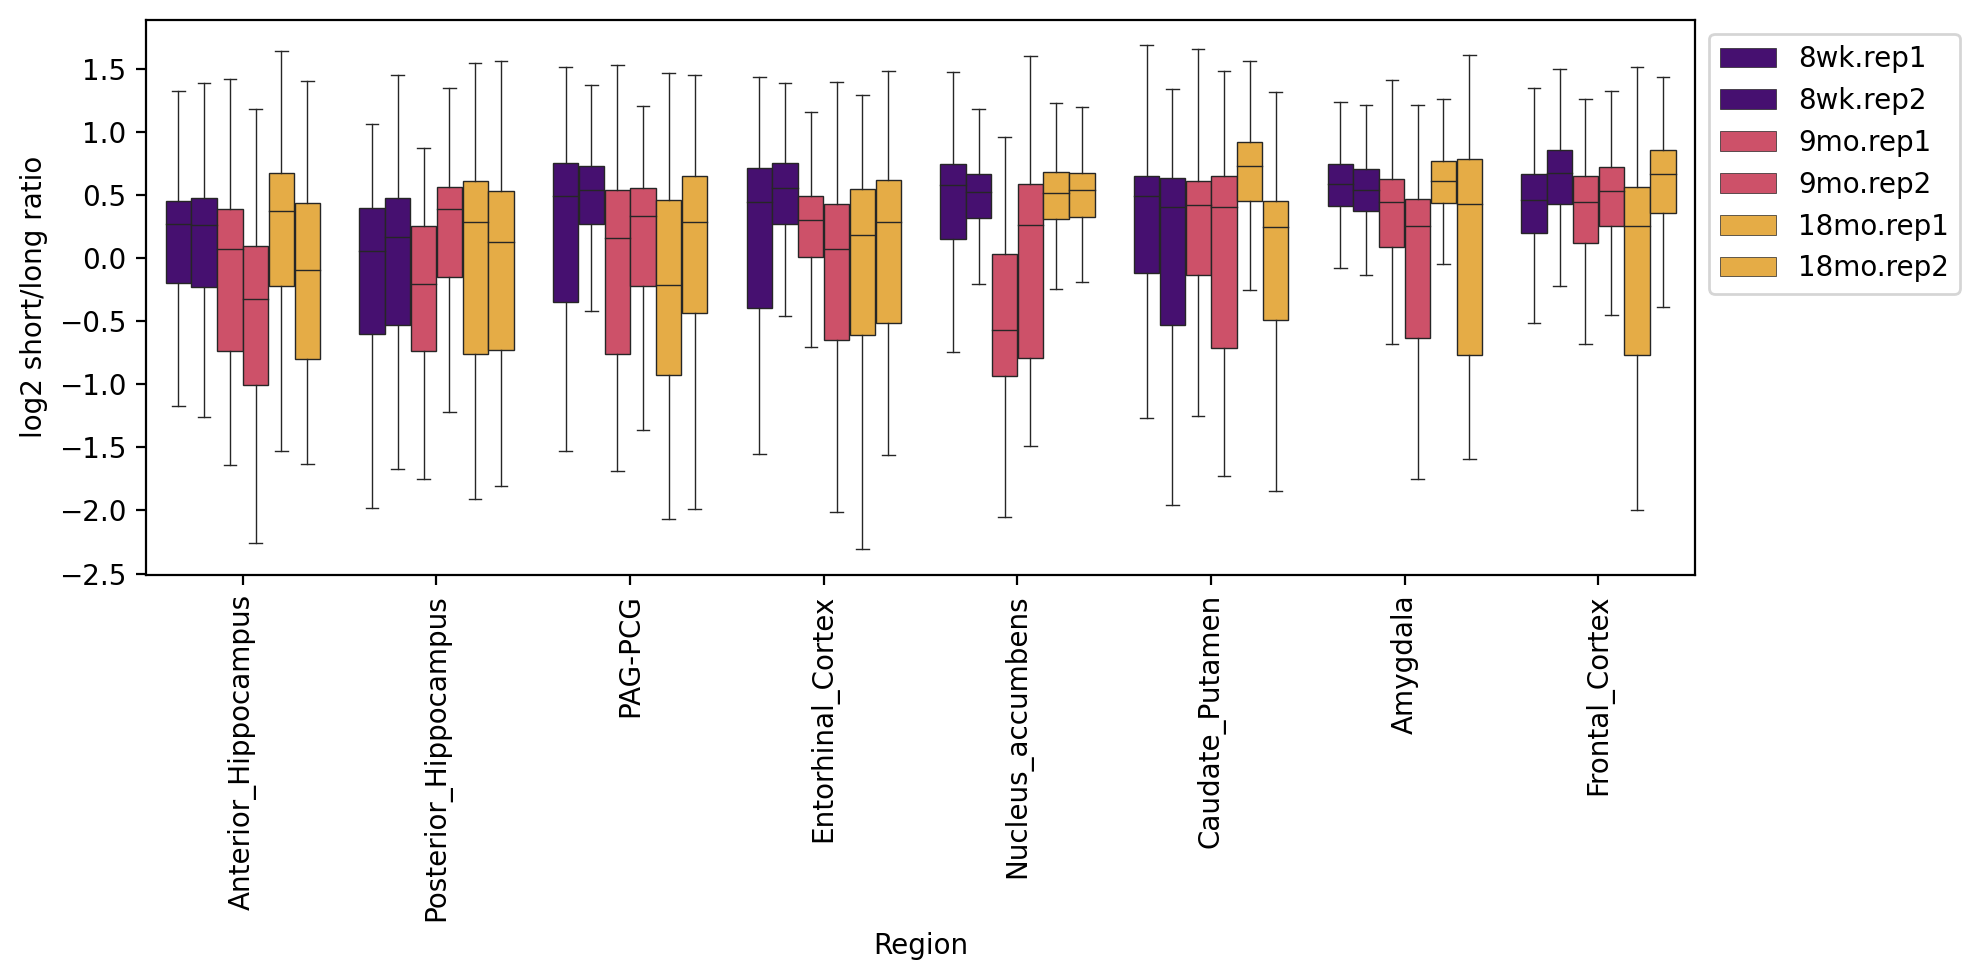

In [19]:
fig, ax = plt.subplots(figsize = (10,5), dpi = 200)
sns.boxplot(data=meta, 
            ax = ax, 
            x=x, y=y, 
            hue=hue,
            linewidth=0.5,
            hue_order = hue_order,
            palette=age_rep_palette,
            showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#ax.set_ylim(-2,1.5)
ax.set_ylabel('log2 short/long ratio')
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()